In [2]:
#作成したテンソルを読み込み
import torch
X_train = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/X_train.pt')
X_test = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/X_test.pt')
X_valid = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/X_valid.pt')
Y_train = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/Y_train.pt')
Y_test = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/Y_test.pt')
Y_valid = torch.load('/content/drive/MyDrive/Colab Notebooks/chapter08/Y_valid.pt')

In [8]:
# モデルの構築
from torch import nn

class MLNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, output_size),
                    )

    def forward(self, x):
        logits = self.layers(x)
        return logits

net = MLNet(300, 256, 4)
print(net)

MLNet(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [4]:
# データセットを作成する
import torch.utils.data as data

#データセットのクラスを作成
class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス

    Attributes
    ----------------------------
    X : テンソル
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X
        self.y = y
        self.phase = phase

    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)

    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])

torch.Size([300])
tensor(2)
torch.Size([300])
tensor(3)
torch.Size([300])
tensor(2)


In [9]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)

    # ネットワークをgpuへ
    net.to(device)

    # ネットワークがある程度固定なら高速化させる
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    #各数値を格納する配列の初期化
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-6, last_epoch=-1) #cosに沿って学習率を減少させる

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
        scheduler.step()
    return train_loss, train_acc, valid_loss, valid_acc

batch_size = 2048
num_epochs = 200

# DataLoaderを作成
train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }
# モデルの定義
net = MLNet(300, 256, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

train_loss, train_acc, valid_loss, valid_acc = \
            train_model(net, dataloaders_dict, criterion, optimizer,
                        num_epochs=num_epochs)

使用デバイス: cuda:0
Epoch 1 / 200 (train) Loss: 1.3594, Acc: 0.3812, (val) Loss: 1.3635, Acc: 0.3973
Epoch 2 / 200 (train) Loss: 1.1180, Acc: 0.5808, (val) Loss: 1.3259, Acc: 0.3966
Epoch 3 / 200 (train) Loss: 0.9357, Acc: 0.7082, (val) Loss: 1.2736, Acc: 0.4190
Epoch 4 / 200 (train) Loss: 0.8055, Acc: 0.7570, (val) Loss: 1.2022, Acc: 0.5420
Epoch 5 / 200 (train) Loss: 0.7126, Acc: 0.7796, (val) Loss: 1.1091, Acc: 0.6484
Epoch 6 / 200 (train) Loss: 0.6455, Acc: 0.7967, (val) Loss: 0.9978, Acc: 0.7196
Epoch 7 / 200 (train) Loss: 0.5948, Acc: 0.8117, (val) Loss: 0.8765, Acc: 0.7534
Epoch 8 / 200 (train) Loss: 0.5554, Acc: 0.8260, (val) Loss: 0.7578, Acc: 0.7886
Epoch 9 / 200 (train) Loss: 0.5217, Acc: 0.8394, (val) Loss: 0.6543, Acc: 0.8163
Epoch 10 / 200 (train) Loss: 0.4934, Acc: 0.8478, (val) Loss: 0.5722, Acc: 0.8433
Epoch 11 / 200 (train) Loss: 0.4690, Acc: 0.8564, (val) Loss: 0.5119, Acc: 0.8613
Epoch 12 / 200 (train) Loss: 0.4481, Acc: 0.8634, (val) Loss: 0.4701, Acc: 0.8696
Epoch 13 /

学習データの正解率: 0.9901
検証データの正解率: 0.9220
テストデータの正解率: 0.9048


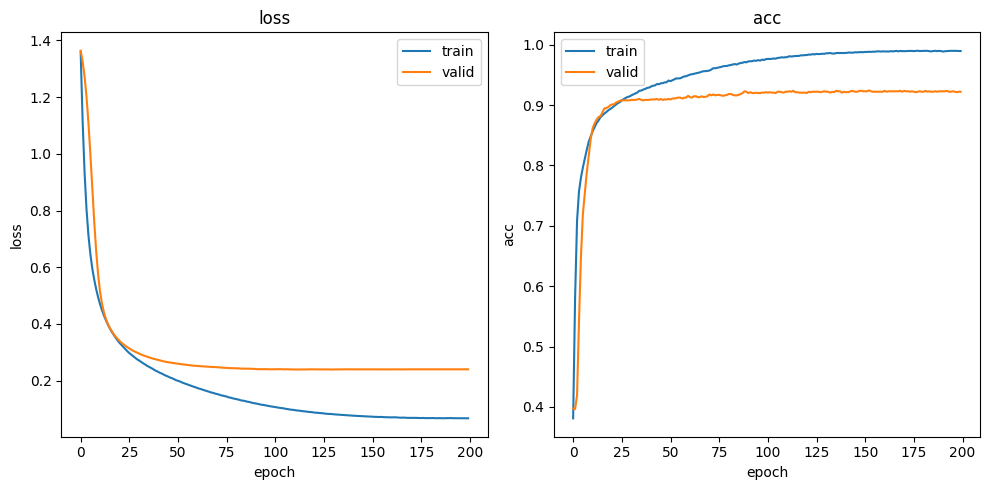

In [12]:
#学習の過程を可視化
from matplotlib import pyplot as plt
import numpy as np

def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig79.png')
plt.show()